### Importando dependências

In [377]:
#from google.colab import drive
#drive.mount('/content/drive')

In [420]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, auc
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [419]:
# Definindo o DataFrame com os resultados das predições dos modelos de cada leva
def build_dataframe(results):
    df = pd.DataFrame(results)
    df['metric'] = (df.precision + df.recall + df.roc) / 3
    df = df.sort_values(by=['metric','precision', 'roc', 'recall'], ascending=False).reset_index(drop=True)
    return df

In [418]:
# Calculando o dicionário com os resultados das predições dos modelos por leva
def plot_model_stats(NCOLS, models, model_names, X_test, y_test, leva):
    fig, ax = plt.subplots(ncols=NCOLS, figsize=(20,4))
    fig.tight_layout()
    
    results = []

    for i in range(NCOLS):
        results += [plot_confusion_matrix(models[i], X_test, y_test, ax[i], model_names[i], leva)]
        ax[i].set_title(model_names[i])

    plt.show()
    return results

In [423]:
# Define o yhat, a matriz de confusão e os scores necessários para um modelo de uma determinada leva
def plot_confusion_matrix(model, X, y, ax, model_name, leva):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot(ax=ax)
    
    data = {
        'model_name': model_name,
#       'model_shape': model.hidden_layer_sizes,
        'leva': leva,
        'precision': round(precision_score(y, y_pred), 4),
        'recall': round(recall_score(y, y_pred), 4),
        'roc': round(roc_auc_score(y, y_pred_prob), 4)
    }
    
    return data

In [379]:
#%cd /content/drive/My Drive/titanic_kaggle/dataset
#train_df = pd.read_csv("train.csv")
#test_df = pd.read_csv("test.csv")

In [380]:
train_df = pd.read_csv("../dataset/train.csv")
test_df = pd.read_csv("../dataset/test.csv")

In [381]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
684,685,0,2,"Brown, Mr. Thomas William Solomon",male,60.0,1,1,29750,39.0000,NaN,S
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C
87,88,0,3,"Slocovski, Mr. Selman Francis",male,NaN,0,0,SOTON/OQ 392086,8.0500,NaN,S
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
600,601,1,2,"Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...",female,24.0,2,1,243847,27.0000,NaN,S


In [382]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Visualizing the data

In [383]:
train_df.shape

(891, 12)

In [384]:
males = train_df[train_df.Sex == 'male']
females = train_df[train_df.Sex == 'female']

In [385]:
males_survived = males.Survived.value_counts().reset_index().rename(columns={'index': 'Survived', 'Survived': 'Count'})
males_survived['Sex'] = 'male'

females_survived = females.Survived.value_counts().reset_index().rename(columns={'index': 'Survived', 'Survived': 'Count'})
females_survived['Sex'] = 'female'

survived_per_sex = pd.concat([males_survived, females_survived], axis=0)

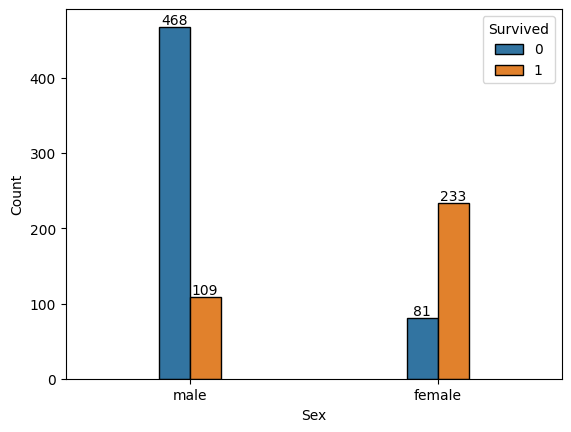

In [386]:
ax = sns.barplot(data=survived_per_sex, x='Sex', y='Count', hue='Survived', width=0.25, edgecolor='black')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

In [387]:
dead = train_df[train_df.Survived == 0].Pclass.value_counts().reset_index().rename(columns={'index': 'Pclass', 'Pclass': 'Count'})
dead['Survived'] = 0

survived = train_df[train_df.Survived == 1].Pclass.value_counts().reset_index().rename(columns={'index': 'Pclass', 'Pclass': 'Count'})
survived['Survived'] = 1

survived_per_pclass = pd.concat([dead, survived], axis=0)

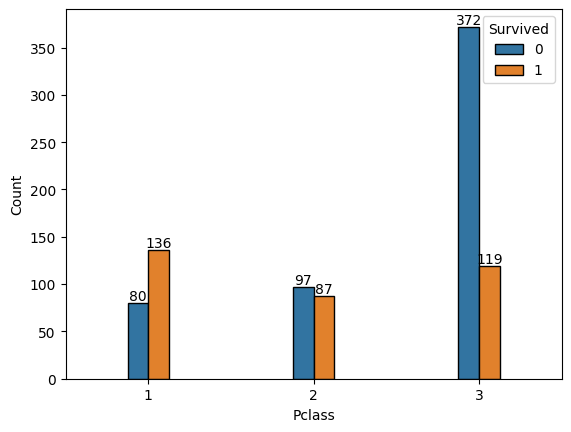

In [388]:
ax = sns.barplot(data=survived_per_pclass, x='Pclass', y='Count', hue='Survived', width=0.25, edgecolor='black')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

<Axes: xlabel='Age', ylabel='Fare'>

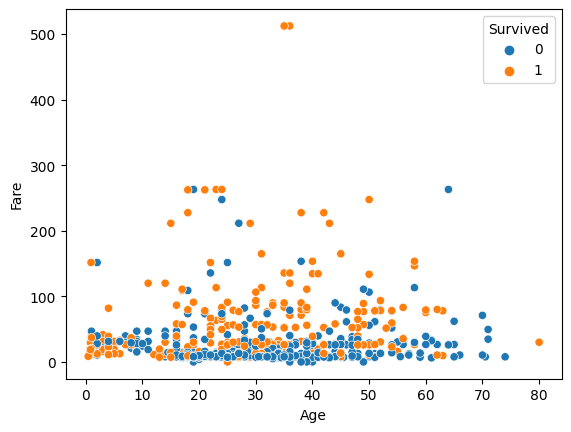

In [389]:
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived')

<Axes: xlabel='Age', ylabel='Count'>

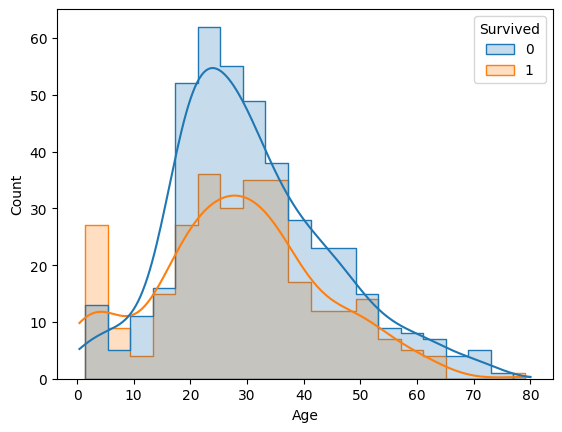

In [390]:
sns.histplot(data=train_df, x='Age', hue='Survived', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<Axes: xlabel='Age', ylabel='Count'>

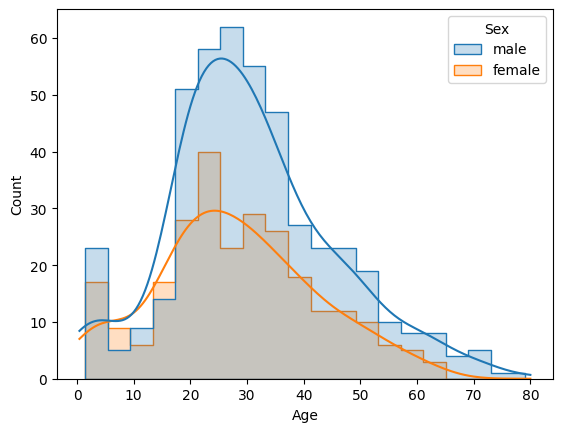

In [391]:
sns.histplot(data=train_df, x='Age', hue='Sex', multiple='layer', shrink=0.5, kde=True, bins=20, element='step')

<Axes: xlabel='Sex', ylabel='Age'>

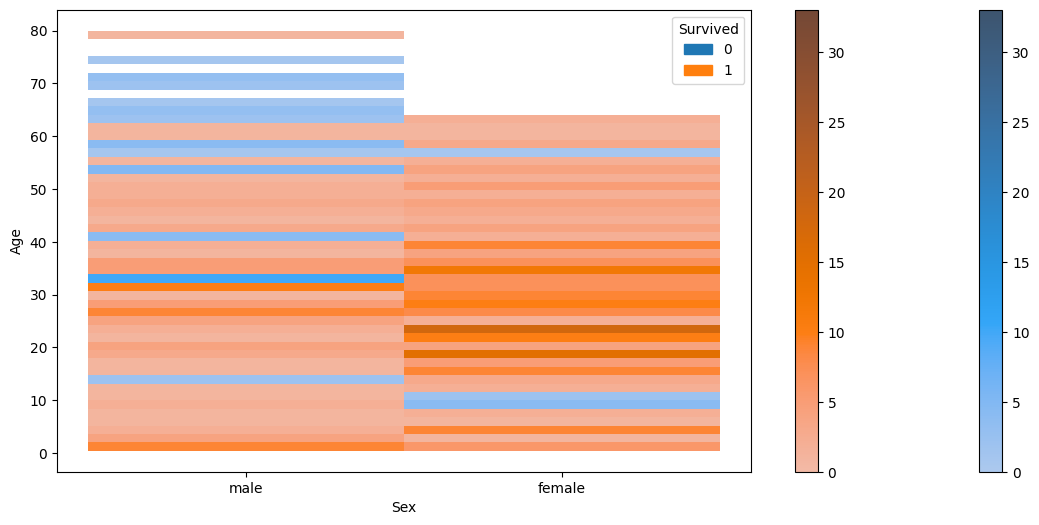

In [392]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=train_df, x='Sex', y='Age', hue='Survived', bins=50, cbar=True, ax=ax)

<Axes: xlabel='Sex', ylabel='Age'>

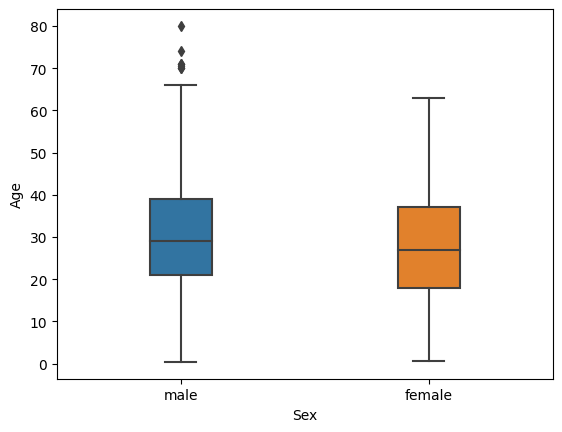

In [393]:
sns.boxplot(data=train_df, x='Sex', y='Age', width=0.25)

<Axes: xlabel='Survived', ylabel='Age'>

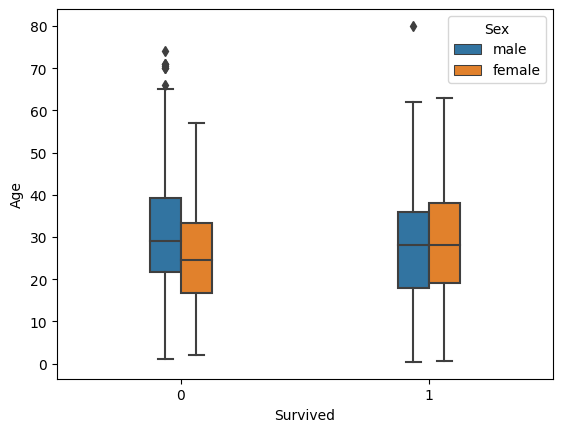

In [394]:
sns.boxplot(data=train_df, x='Survived', y='Age', hue='Sex', width=0.25)

<Axes: xlabel='Survived', ylabel='Fare'>

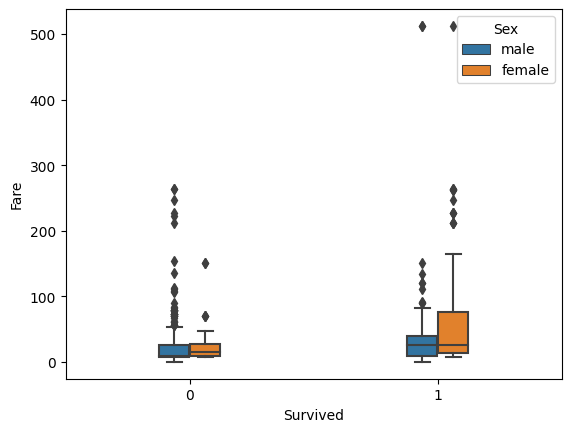

In [395]:
sns.boxplot(data=train_df, x='Survived', y='Fare', hue='Sex', width=0.25)

### Preprocessing

In [396]:
percent = train_df.isnull().mean()
percent

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [397]:
most_null_cols = percent[percent > 0.75].index
train_df = train_df.drop(columns=most_null_cols)
train_df.sample(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
853,854,1,1,"Lines, Miss. Mary Conover",female,16.0,0,1,PC 17592,39.4,S


In [398]:
train_df = train_df.drop(columns=['PassengerId', 'Name','Ticket']) # useless features
#test_df = test_df.drop(columns=['PassengerId', 'Name','Cabin', 'Ticket'])

In [399]:
train_df.sample(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
547,1,2,male,NaN,0,0,13.8625,C


In [400]:
types = train_df.dtypes.reset_index()
types.columns = ['Feature', 'type']
types

,Feature,type
0,Survived,int64
1,Pclass,int64
2,Sex,object
3,Age,float64
4,SibSp,int64
5,Parch,int64
6,Fare,float64
7,Embarked,object


In [401]:
CATEGORICAL_FEATURES = [col for col in train_df.columns if train_df[col].dtype == 'object']
NUMERICAL_FEATURES = [col for col in train_df.columns if train_df[col].dtype != 'object']

In [402]:
#train_df = train_df.fillna(np.NaN)

In [403]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [404]:


num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

train_df[NUMERICAL_FEATURES] = num_imputer.fit_transform(train_df[NUMERICAL_FEATURES])
train_df[CATEGORICAL_FEATURES] = cat_imputer.fit_transform(train_df[CATEGORICAL_FEATURES])

In [405]:
train_df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [406]:
train_df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
884,0.0,3.0,male,25.0,0.0,0.0,7.05,S
472,1.0,2.0,female,33.0,1.0,2.0,27.75,S
148,0.0,2.0,male,36.5,0.0,2.0,26.00,S
654,0.0,3.0,female,18.0,0.0,0.0,6.75,Q
353,0.0,3.0,male,25.0,1.0,0.0,17.80,S


In [407]:
oe = OrdinalEncoder()

train_df[CATEGORICAL_FEATURES] = oe.fit_transform(train_df[CATEGORICAL_FEATURES])

In [408]:
train_df.sample(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
252,0.0,1.0,1.0,62.0,0.0,0.0,26.550,2.0
89,0.0,3.0,1.0,24.0,0.0,0.0,8.050,2.0
661,0.0,3.0,1.0,40.0,0.0,0.0,7.225,0.0
70,0.0,2.0,1.0,32.0,0.0,0.0,10.500,2.0
657,0.0,3.0,0.0,32.0,1.0,1.0,15.500,1.0


In [409]:
# Matriz de features X e vetor TARGET y
X_ = train_df.loc[:, train_df.columns != 'Survived']
y_ = train_df.Survived

# Separando a base pré-processada em bases treino e teste
# seguindo uma proporção de 25% para a de teste
X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=0.25, random_state=42)

In [410]:
# Inicializando scaler para realizar scaling nas
# matrizes de features de treino e teste
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [411]:
X_train.shape

(668, 7)

In [431]:
seed = 42
tree_1 = DecisionTreeClassifier(criterion='gini', random_state=seed).fit(X_train, y_train)
tree_2 = DecisionTreeClassifier(criterion='entropy', random_state=seed).fit(X_train, y_train)
tree_3 = DecisionTreeClassifier(criterion='log_loss', random_state=seed).fit(X_train, y_train)

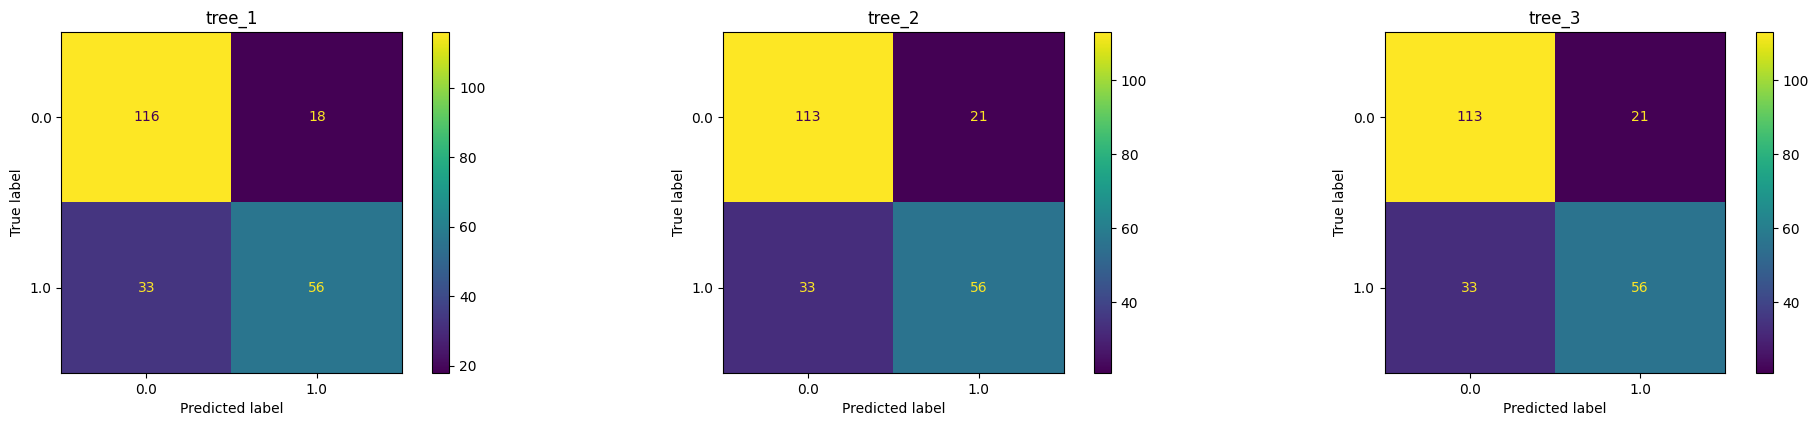

In [433]:
results_1 = plot_model_stats(3, [tree_1, tree_2, tree_3], ['tree_1', 'tree_2', 'tree_3'], X_test, y_test, 1)

Melhor criterion é o gini

In [434]:
results_1 = build_dataframe(results_1)
results_1

,model_name,leva,precision,recall,roc,metric
0,tree_1,1,0.7568,0.6292,0.7474,0.711133
1,tree_2,1,0.7273,0.6292,0.7362,0.697567
2,tree_3,1,0.7273,0.6292,0.7362,0.697567


In [435]:
tree_4 = DecisionTreeClassifier(splitter='best', random_state=seed).fit(X_train, y_train)
tree_5 = DecisionTreeClassifier(splitter='random', random_state=seed).fit(X_train, y_train)

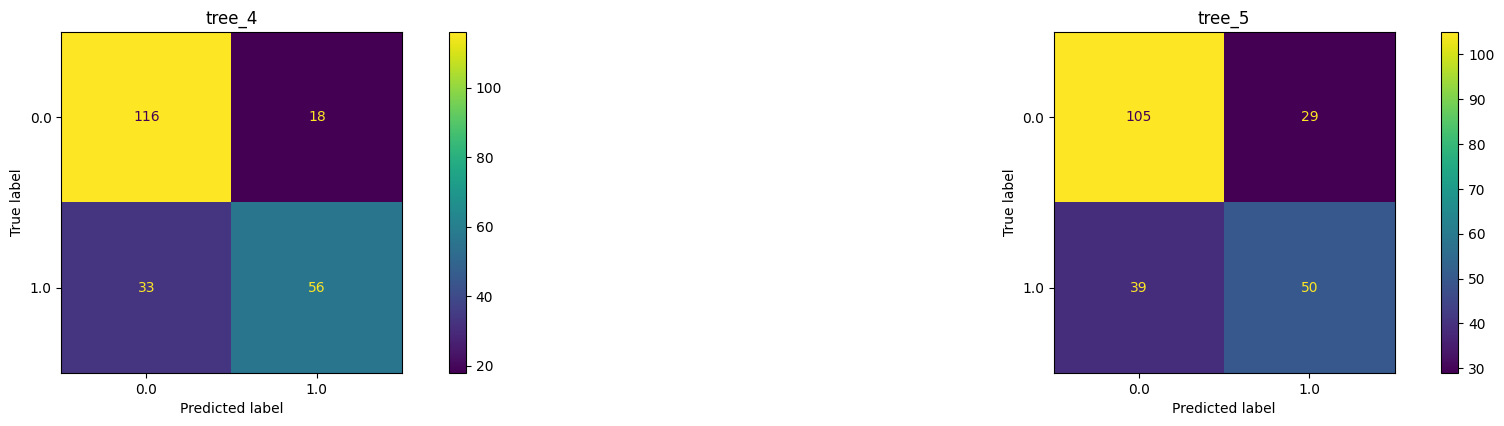

In [436]:
results_2 = plot_model_stats(2, [tree_4, tree_5], ['tree_4', 'tree_5'], X_test, y_test, 2)

In [437]:
results_2 = build_dataframe(results_2)
results_2

,model_name,leva,precision,recall,roc,metric
0,tree_4,2,0.7568,0.6292,0.7474,0.711133
1,tree_5,2,0.6329,0.5618,0.6694,0.621367


In [453]:
tree_6 = DecisionTreeClassifier(min_samples_split=3, random_state=seed).fit(X_train, y_train)
tree_7 = DecisionTreeClassifier(min_samples_split=5, random_state=seed).fit(X_train, y_train)

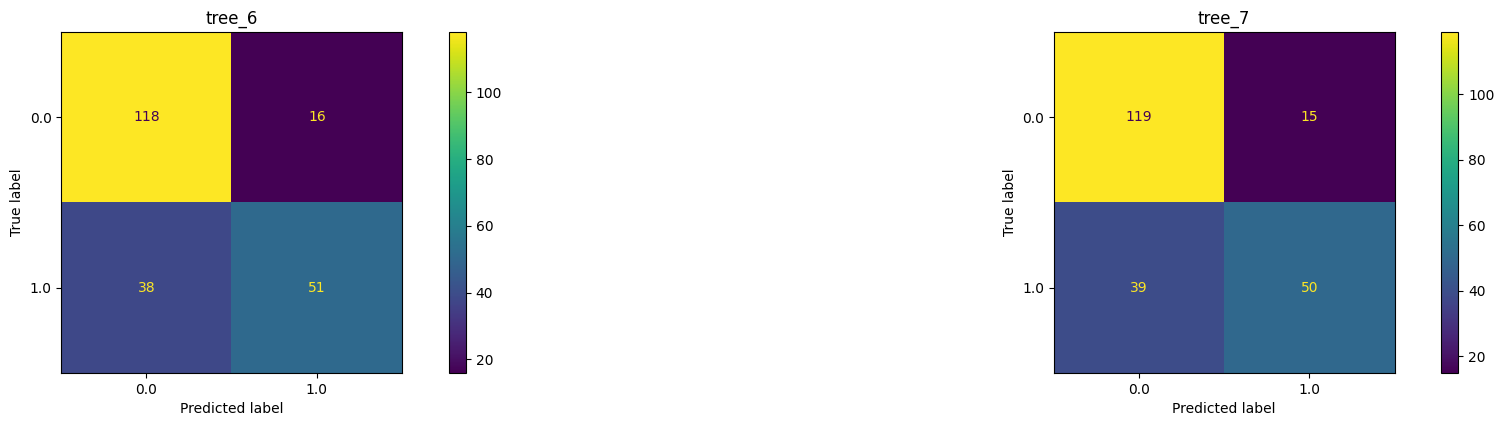

In [454]:
results_3 = plot_model_stats(2, [tree_6, tree_7], ['tree_6', 'tree_7'], X_test, y_test, 3)

In [455]:
results_3 = build_dataframe(results_3)
results_3

,model_name,leva,precision,recall,roc,metric
0,tree_7,3,0.7692,0.5618,0.7652,0.698733
1,tree_6,3,0.7612,0.5730,0.7600,0.698067


In [580]:
tree_8 = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=10, random_state=seed).fit(X_train, y_train)
tree_9 = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=20, random_state=seed).fit(X_train, y_train)
tree_10 = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=30, random_state=seed).fit(X_train, y_train)

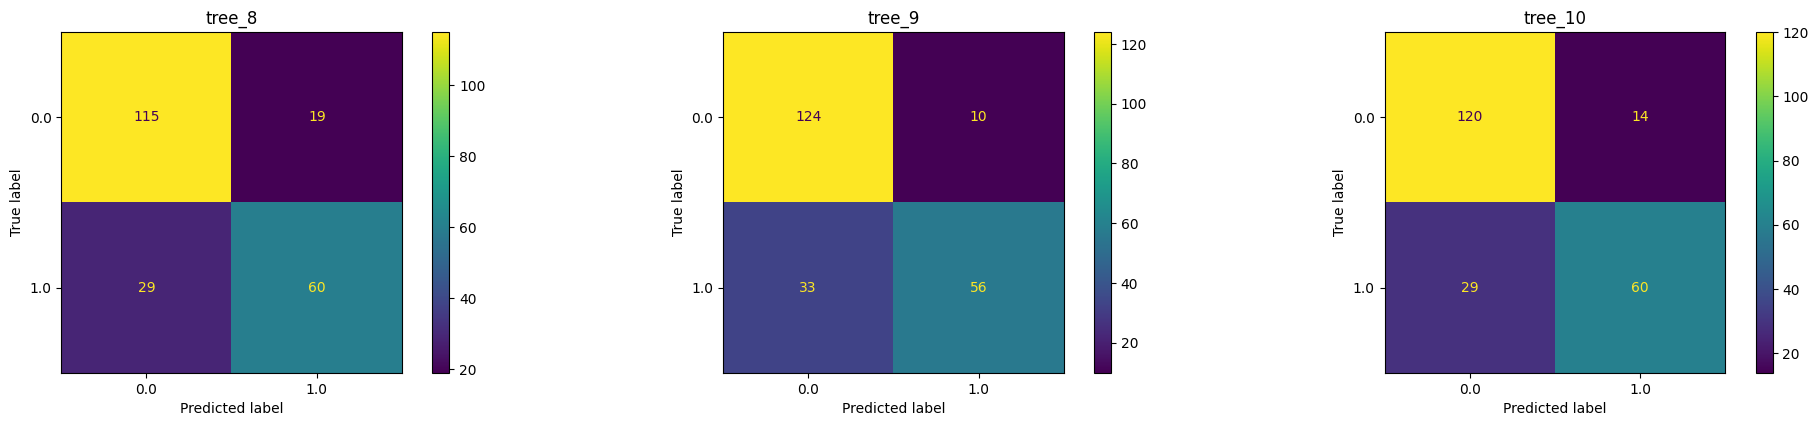

In [581]:
results_4 = plot_model_stats(3, [tree_8, tree_9, tree_10], ['tree_8', 'tree_9', 'tree_10'], X_test, y_test, 4)

In [577]:
results_4 = build_dataframe(results_4)
results_4

,model_name,leva,precision,recall,roc,metric
0,tree_10,4,0.8108,0.6742,0.8703,0.785100
1,tree_9,4,0.8485,0.6292,0.8339,0.770533
2,tree_8,4,0.7595,0.6742,0.8256,0.753100


In [631]:
tree_11 = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=30, max_leaf_nodes=4, random_state=seed).fit(X_train, y_train)
tree_12 = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=30, max_leaf_nodes=5, random_state=seed).fit(X_train, y_train)
tree_13 = DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=30, max_leaf_nodes=6, random_state=seed).fit(X_train, y_train)

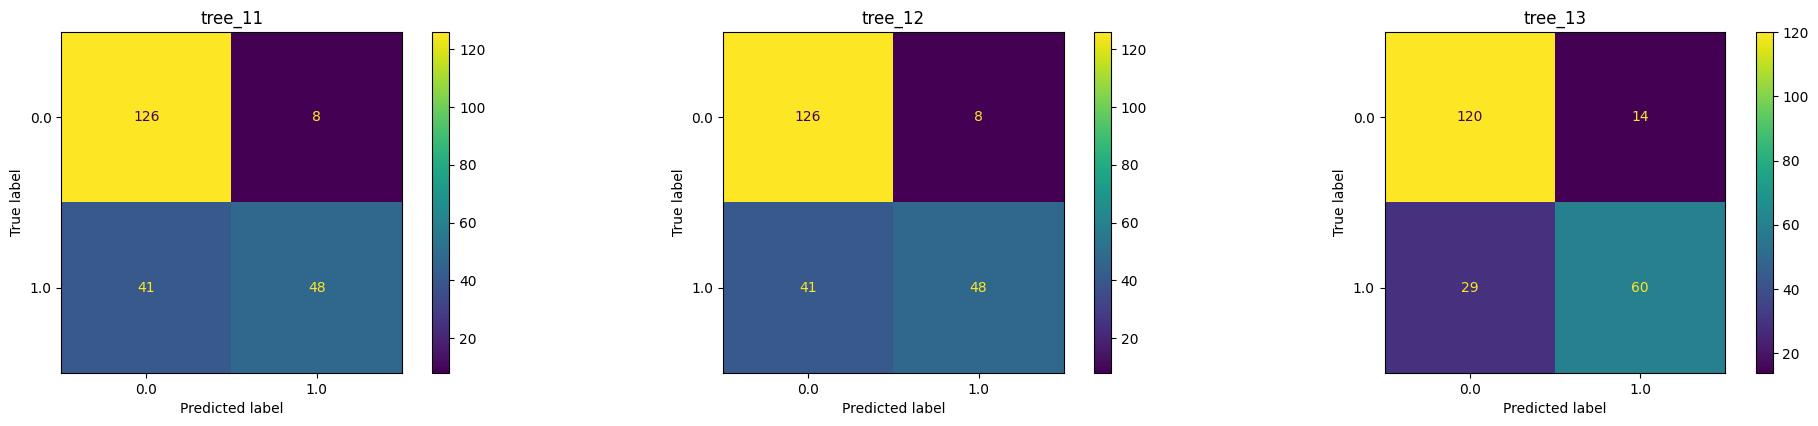

In [632]:
results_5 = plot_model_stats(3, [tree_11, tree_12, tree_13], ['tree_11', 'tree_12', 'tree_13'], X_test, y_test, 5)

In [633]:
results_5 = build_dataframe(results_5)
results_5

,model_name,leva,precision,recall,roc,metric
0,tree_13,5,0.8108,0.6742,0.8611,0.782033
1,tree_12,5,0.8571,0.5393,0.8556,0.750667
2,tree_11,5,0.8571,0.5393,0.8107,0.735700
